### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

# Analisis de datos con Oracle-ADS

### importar de librerias

In [8]:
import ads
import pandas as pd 
import seaborn as sns

### versiones de librerias

In [9]:
ads.__version__

'2.7.2'

In [10]:
pd.__version__

'1.5.2'

In [11]:
sns.__version__

'0.12.2'

### Importar el archivo de base de datos

In [12]:
from ads.dataset.factory import DatasetFactory
data = DatasetFactory.open('framingham.csv', type_discovery=False )
type(data)

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

ads.dataset.dataset.ADSDataset

In [17]:
data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [18]:
data.columns

Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

### Traduciendo las variables

In [19]:
columnasEsp={
    'male':'Sexo',
    'age':'Edad',
    'education':'Educación',
    'currentSmoker':'Fumador',
    'cigsPerDay':'Cigarrillos_por_dia',
    'BPMeds':'Medicamentos_presion',
    'prevalentStroke':'ACV',
    'prevalentHyp':'Hipertension',
    'diabetes':'Diabetes', 
    'totChol':'Colesterol_total', 
    'sysBP':'Presion_sistolica',
    'diaBP':'Presion_Diastolica',
    'BMI':'IMC',
    'heartRate':'Frecuencia_Cardiaca',
    'glucose':'Glicemia',
    'TenYearCHD':'Reizgo_EAC_decada'
}

data = data.rename_columns(columns=columnasEsp)
data.head()

,Sexo,Edad,Educación,Fumador,Cigarrillos_por_dia,Medicamentos_presion,ACV,Hipertension,Diabetes,Colesterol_total,Presion_sistolica,Presion_Diastolica,IMC,Frecuencia_Cardiaca,Glicemia,Reizgo_EAC_decada
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


### Eliminacion de datos no útiles

In [20]:
data = data.drop_columns('Educación')
data.head()

,Sexo,Edad,Fumador,Cigarrillos_por_dia,Medicamentos_presion,ACV,Hipertension,Diabetes,Colesterol_total,Presion_sistolica,Presion_Diastolica,IMC,Frecuencia_Cardiaca,Glicemia,Reizgo_EAC_decada
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


### Visualización de tipo de datos

In [21]:
data.summary()

,Feature,Datatype
0,Sexo,ordinal/int64
1,Edad,ordinal/int64
2,Fumador,ordinal/int64
3,Cigarrillos_por_dia,continuous/float64
4,Medicamentos_presion,continuous/float64
5,ACV,ordinal/int64
6,Hipertension,ordinal/int64
7,Diabetes,ordinal/int64
8,Colesterol_total,continuous/float64
9,Presion_sistolica,continuous/float64


### Búsqueda de datos faltantes

In [22]:
data.isnull().sum()

Sexo                      0
Edad                      0
Fumador                   0
Cigarrillos_por_dia      29
Medicamentos_presion     53
ACV                       0
Hipertension              0
Diabetes                  0
Colesterol_total         50
Presion_sistolica         0
Presion_Diastolica        0
IMC                      19
Frecuencia_Cardiaca       1
Glicemia                388
Reizgo_EAC_decada         0
dtype: int64

### Eliminación de faltantes
Se eliminan los que no afectan la muestra

In [23]:
data = data[data.Cigarrillos_por_dia.notnull()]
data = data[data.Medicamentos_presion.notnull()]
data = data[data.Colesterol_total.notnull()]
data = data[data.IMC.notnull()]
data = data[data.Frecuencia_Cardiaca.notnull()]
data.isnull().sum()

Sexo                      0
Edad                      0
Fumador                   0
Cigarrillos_por_dia       0
Medicamentos_presion      0
ACV                       0
Hipertension              0
Diabetes                  0
Colesterol_total          0
Presion_sistolica         0
Presion_Diastolica        0
IMC                       0
Frecuencia_Cardiaca       0
Glicemia                339
Reizgo_EAC_decada         0
dtype: int64

### Análisis de la variable Glicenia
Se relaciona directamente con la variable dibetes

In [28]:
data.Diabetes.value_counts()

0    3984
1     104
Name: Diabetes, dtype: int64

In [29]:
diabeticos = data[data.Diabetes==1]
noDiabeticos = data[data.Diabetes==0]

In [30]:
diabeticos.Glicemia.mean()

169.87254901960785

In [31]:
noDiabeticos.Glicemia.mean()

79.42226487523992

In [32]:
data.Glicemia.mean()

81.88316884502534

In [101]:
data.Diabetes.value_counts(normalize=True)

0    0.97456
1    0.02544
Name: Diabetes, dtype: float64

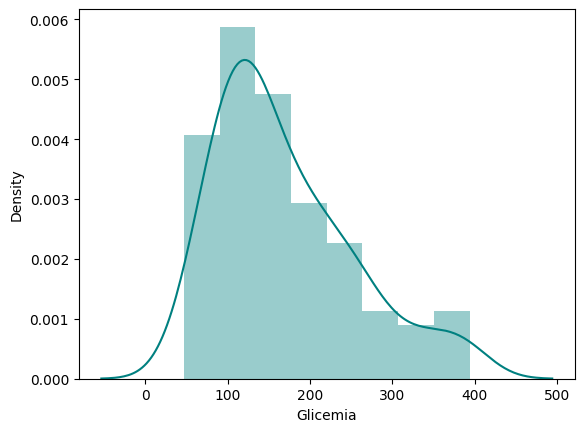

In [34]:
ax = sns.distplot(diabeticos.Glicemia)

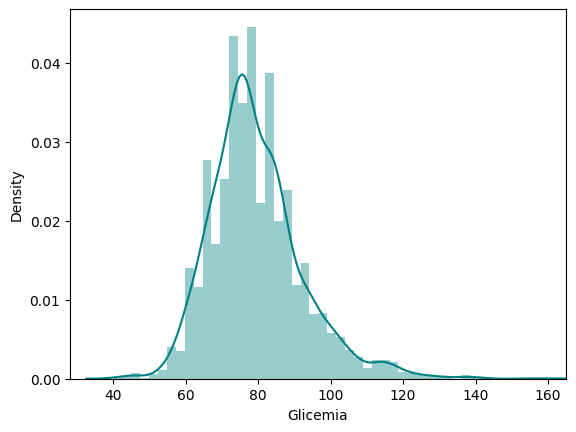

In [35]:
ax = sns.distplot(noDiabeticos.Glicemia)
ax.set_xlim(28,165);

### Remplazando faltantes
del total de faltantes solo 2 son diabeticos, se aplica el promedia de la columna glicemia, por el analisis aplicado antes

In [136]:
faltantes = data.Glicemia.isnull()

In [138]:
data.Diabetes[faltantes].value_counts()

Series([], Name: Diabetes, dtype: int64)

In [139]:
promedioGlicemia = data.Glicemia.mean()
data.fillna({'Glicemia':promedioGlicemia}, inplace=True)
data.isnull().sum()

Sexo                    0
Edad                    0
Fumador                 0
Cigarrillos_por_dia     0
Medicamentos_presion    0
ACV                     0
Hipertension            0
Diabetes                0
Colesterol_total        0
Presion_sistolica       0
Presion_Diastolica      0
IMC                     0
Frecuencia_Cardiaca     0
Glicemia                0
Reizgo_EAC_decada       0
dtype: int64

In [140]:
data.head(100)

,Sexo,Edad,Fumador,Cigarrillos_por_dia,Medicamentos_presion,ACV,Hipertension,Diabetes,Colesterol_total,Presion_sistolica,Presion_Diastolica,IMC,Frecuencia_Cardiaca,Glicemia,Reizgo_EAC_decada
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,0,56,1,15.0,0.0,0,0,0,269.0,121.0,75.0,22.36,50.0,66.0,0
100,0,47,1,20.0,0.0,0,0,0,220.0,132.5,87.0,27.98,65.0,75.0,0
101,0,60,0,0.0,0.0,0,1,0,275.0,141.0,84.0,29.66,75.0,105.0,0
102,0,45,1,9.0,0.0,0,0,0,268.0,110.0,64.0,20.68,63.0,71.0,0


In [141]:
data.shape

(4088, 15)

### se analizan los datos nuevamente

In [142]:
data.summary()

,Feature,Datatype
0,Sexo,ordinal/int64
1,Edad,ordinal/int64
2,Fumador,ordinal/int64
3,Cigarrillos_por_dia,continuous/float64
4,Medicamentos_presion,continuous/float64
5,ACV,ordinal/int64
6,Hipertension,ordinal/int64
7,Diabetes,ordinal/int64
8,Colesterol_total,continuous/float64
9,Presion_sistolica,continuous/float64


### Se trabajara la variable "cigarrillos por dia"
se convertira a datos enteros ya que no tiene sentido que sean boolean

In [143]:
data = data.astype(types={'Cigarrillos_por_dia':'int64'})

In [144]:
data = data.astype(types={'Medicamentos_presion':'int64'})

In [145]:
data.summary()

,Feature,Datatype
0,Sexo,ordinal/int64
1,Edad,ordinal/int64
2,Fumador,ordinal/int64
3,Cigarrillos_por_dia,ordinal/int64
4,Medicamentos_presion,ordinal/int64
5,ACV,ordinal/int64
6,Hipertension,ordinal/int64
7,Diabetes,ordinal/int64
8,Colesterol_total,continuous/float64
9,Presion_sistolica,continuous/float64


In [146]:
data.Cigarrillos_por_dia.describe()

count    4088.000000
mean        8.992417
std        11.910941
min         0.000000
25%         0.000000
50%         0.000000
75%        20.000000
max        70.000000
Name: Cigarrillos_por_dia, dtype: float64

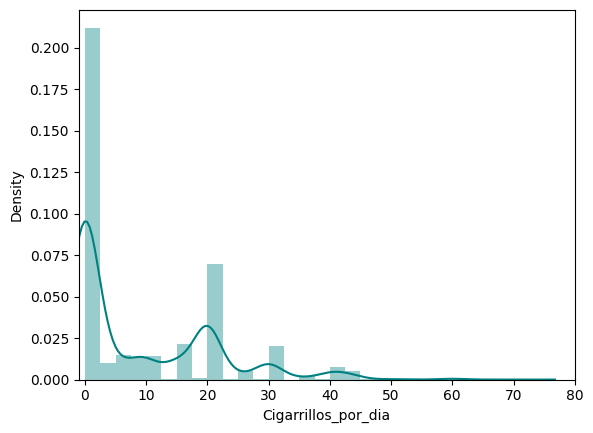

In [147]:
ax = sns.distplot(data.Cigarrillos_por_dia)
ax.set_xlim(-1,80);

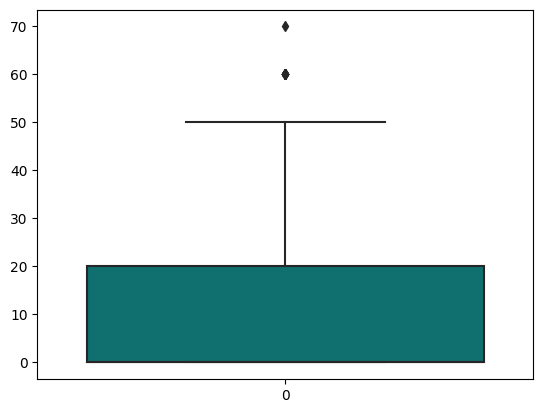

In [148]:
ax = sns.boxplot(data.Cigarrillos_por_dia);

### se agrupan los datos en una nueva variable para analizarlos

In [149]:
categorias = [0,1,2,3]
limites = [-1,1,11,21,71]

In [150]:
Categoria_fumador = pd.cut(data.Cigarrillos_por_dia, limites, labels=categorias)

In [151]:
data = data.assign_column('Categoria_fumador',Categoria_fumador)
data.columns

Index(['Sexo', 'Edad', 'Fumador', 'Cigarrillos_por_dia',
       'Medicamentos_presion', 'ACV', 'Hipertension', 'Diabetes',
       'Colesterol_total', 'Presion_sistolica', 'Presion_Diastolica', 'IMC',
       'Frecuencia_Cardiaca', 'Glicemia', 'Reizgo_EAC_decada',
       'Categoria_fumador'],
      dtype='object')

In [154]:
data.head()

,Sexo,Edad,Fumador,Cigarrillos_por_dia,Medicamentos_presion,ACV,Hipertension,Diabetes,Colesterol_total,Presion_sistolica,Presion_Diastolica,IMC,Frecuencia_Cardiaca,Glicemia,Reizgo_EAC_decada,Categoria_fumador
0,1,39,0,0,0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0,0
1,0,46,0,0,0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0,0
2,1,48,1,20,0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0,2
3,0,61,1,30,0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1,3
4,0,46,1,23,0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0,3


In [157]:
data.show_in_notebook()

Accordion(children=(HTML(value='<h3>Type: ADSDataset</h3><h3>4,088 Rows, 16 Columns</h3><h4>Column Types:</h4>…

In [158]:
data.corr()

,Colesterol_total,Fumador,Frecuencia_Cardiaca,Presion_Diastolica,Cigarrillos_por_dia,Sexo,Glicemia,Hipertension,IMC,ACV,Edad,Presion_sistolica,Medicamentos_presion,Diabetes,Reizgo_EAC_decada
Colesterol_total,1.000000,-0.048494,0.089519,0.167580,-0.026620,-0.065808,0.044932,0.163659,0.121683,0.007670,0.262911,0.211712,0.082272,0.043748,0.080676
Fumador,-0.048494,1.000000,0.057172,-0.107839,0.769987,0.199287,-0.051880,-0.102312,-0.170169,-0.032002,-0.215080,-0.130159,-0.048777,-0.043453,0.025360
Frecuencia_Cardiaca,0.089519,0.057172,1.000000,0.178012,0.071100,-0.114814,0.094465,0.147475,0.070806,-0.011750,-0.011746,0.182966,0.013895,0.053966,0.025715
Presion_Diastolica,0.167580,-0.107839,0.178012,1.000000,-0.050922,0.060364,0.059736,0.613649,0.382157,0.048708,0.203561,0.784676,0.195667,0.052245,0.147684
Cigarrillos_por_dia,-0.026620,0.769987,0.071100,-0.050922,1.000000,0.322215,-0.052879,-0.062994,-0.090474,-0.033362,-0.190383,-0.085891,-0.043939,-0.038379,0.063060
Sexo,-0.065808,0.199287,-0.114814,0.060364,0.322215,1.000000,0.003106,0.009135,0.080700,-0.003798,-0.023015,-0.032574,-0.050173,0.015020,0.096060
Glicemia,0.044932,-0.051880,0.094465,0.059736,-0.052879,0.003106,1.000000,0.082509,0.084139,0.015415,0.113779,0.128141,0.051086,0.609578,0.119826
Hipertension,0.163659,-0.102312,0.147475,0.613649,-0.062994,0.009135,0.082509,1.000000,0.304447,0.066541,0.303271,0.693520,0.259934,0.076787,0.173806
IMC,0.121683,-0.170169,0.070806,0.382157,-0.090474,0.080700,0.084139,0.304447,1.000000,0.030565,0.134536,0.329870,0.102511,0.086747,0.076643
ACV,0.007670,-0.032002,-0.011750,0.048708,-0.033362,-0.003798,0.015415,0.066541,0.030565,1.000000,0.044201,0.054581,0.125864,0.009350,0.044186


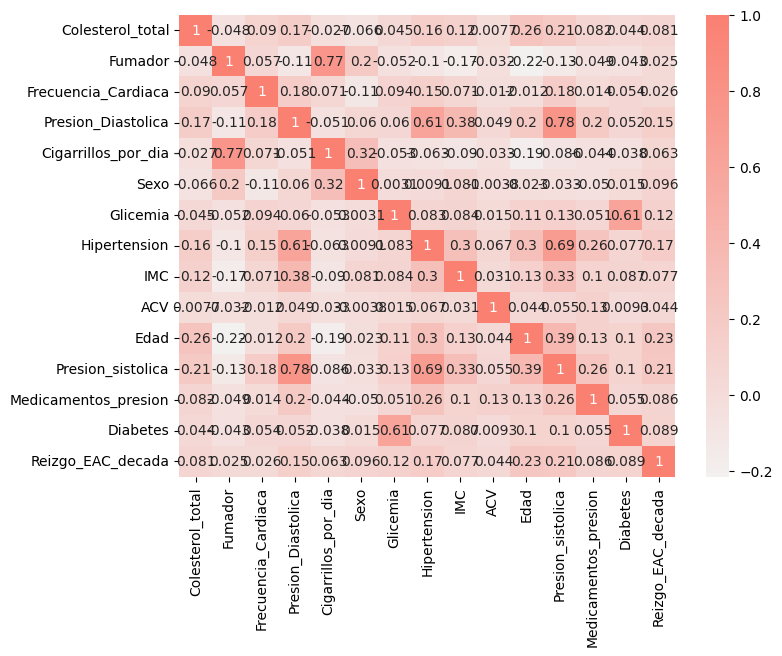

In [159]:

plt.figure(figsize=[8,6])
paleta = sns.color_palette('light:salmon', as_cmap=True)
sns.heatmap(data.corr(), annot=True, cmap=paleta);

In [160]:
from ads.dataset.factory import DatasetFactory
bd = DatasetFactory.open('./framingham.csv',target='TenYearCHD')
bd.head()

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [161]:
bd = bd.rename_columns(columnasEsp)
bd.head()

,Sexo,Edad,Educación,Fumador,Cigarrillos_por_dia,Medicamentos_presion,ACV,Hipertension,Diabetes,Colesterol_total,Presion_sistolica,Presion_Diastolica,IMC,Frecuencia_Cardiaca,Glicemia,Reizgo_EAC_decada
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [162]:
bd.suggest_recommendations()

Code
Message                                              Variables            Suggested                         Action                                                                          
Contains missing values(105)                         Educación            Fill missing values with frequent Drop                                                .drop_columns(["Educación"])
                                                                                                            Fill missing values with frequent                    .fillna({"Educación": 1.0})
                                                                                                            Fill missing values with constant             .fillna({"Educación": "constant"})
                                                                                                            Do nothing                                                                      
Contains missing values(29)                          Cigarrillos_por_dia  Fill missing values with frequent Drop                                      .drop_columns(["Cigarrillos_por_dia"])
                                                                                                            Fill missing values with frequent          .fillna({"Cigarrillos_por_dia": 0.0})
                                                                                                            Fill missing values with constant   .fillna({"Cigarrillos_por_dia": "constant"})
                                                                                                            Do nothing                                                                      
Contains missing values(53)                          Medicamentos_presion Fill missing values with frequent Drop                                     .drop_columns(["Medicamentos_presion"])
                                                                                                            Fill missing values with frequent         .fillna({"Medicamentos_presion": 0.0})
                                                                                                            Fill missing values with constant  .fillna({"Medicamentos_presion": "constant"})
                                                                                                            Do nothing                                                                      
Contains missing values(50)                          Colesterol_total     Fill missing values with frequent Drop                                         .drop_columns(["Colesterol_total"])
                                                                                                            Fill missing values with frequent           .fillna({"Colesterol_total": 240.0})
                                                                                                            Fill missing values with constant      .fillna({"Colesterol_total": "constant"})
                                                                                                            Do nothing                                                                      
Contains missing values(19)                          IMC                  Fill missing values with mean     Drop                                                      .drop_columns(["IMC"])
                                                                                                            Fill missing values with mean                           .fillna({"IMC": 25.802})
                                                                                                            Fill missing values with median                           .fillna({"IMC": 25.4})
                                                                                                            Fill missing values with frequent                        .fillna({"IMC": 22.19})
                          

In [163]:
bd=bd.auto_transform()

loop1:   0%|          | 0/7 [00:00<?, ?it/s]

In [164]:
bd.show_in_notebook()

Accordion(children=(HTML(value='<h3>Type: BinaryClassificationDataset</h3><h3>4,238 Rows, 15 Columns</h3><h4>C…

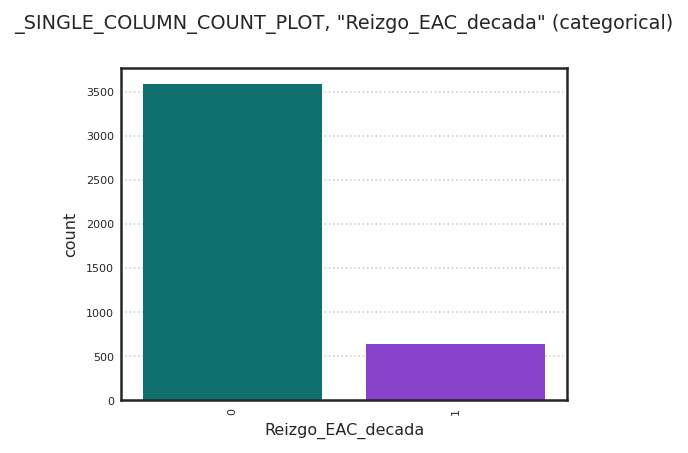

In [165]:
bd.target.show_in_notebook()

In [166]:
bd.Reizgo_EAC_decada.value_counts()

0    3594
1     644
Name: Reizgo_EAC_decada, dtype: int64

In [167]:
bd.Reizgo_EAC_decada.value_counts(normalize=True)

0    0.848042
1    0.151958
Name: Reizgo_EAC_decada, dtype: float64

In [168]:
import imblearn
bd_sobremuestreado = bd.up_sample(sampler='default')

In [169]:
bd_sobremuestreado.show_in_notebook()

Accordion(children=(HTML(value='<h3>Type: BinaryClassificationDataset</h3><h3>7,188 Rows, 15 Columns</h3><h4>C…

In [170]:
bd_submuestreado = bd.down_sample()

In [171]:
bd_submuestreado.show_in_notebook()

Accordion(children=(HTML(value='<h3>Type: BinaryClassificationDataset</h3><h3>1,288 Rows, 15 Columns</h3><h4>C…

In [172]:
bd_sobremuestreado.Reizgo_EAC_decada.value_counts()

0    3594
1    3594
Name: Reizgo_EAC_decada, dtype: int64

In [173]:
bd_submuestreado.Reizgo_EAC_decada.value_counts()

0    644
1    644
Name: Reizgo_EAC_decada, dtype: int64

In [174]:
#Generando una descripción para el DataFrame
descripcion = """
- Información general: Esta base de datos se refiere a un estudio realizado recolectando datos sobre el estado de salud de los pacientes para tratar de clasificar el riesgo de enfermedad coronaria en los próximos 10 años. Para consultar la base original, puede acceder al siguiente [link](https://www.kaggle.com/dileep070/heart-disease-prediction-using-logistic-regression).

Los datos fueron modificados con el objetivo de corregir los problemas de la base y dejarla lista para poder realizar modelos empleando Machine Learning.

-Tipo de las Columnas:
    - 'sexo': booleano,
    - 'edad': numérico,
    - 'cigarrillos_por_dia': categórico,                                                                   
    - 'uso_medicamento_presion': booleano
    - 'acv': booleano,
    - 'hipertension': booleano,
    - 'diabetes': booleano,
    - 'colesterol_total': numérico,
    - 'presion_arterial_sistolica': numérico,
    - 'presion_arterial_diastolica': numérico,
    - 'imc': numérico,
    - 'frecuencia_cardiaca': numérico,
    - 'glicemia': numérico,
    - 'riesgo_EAC_decada': booleano.

- Detalle de las Columnas:
    - 'sexo': Considera masculino como 1 y femenino como 0;
    - 'edad': Edad en años completos;
- 'cigarrillos_por_dia': Define diferentes grupos de personas de acuerdo con la cantidad de cigarrillos consumidos por día:
    0 - no fumador;
    1 - fumador leve (1 a 10 cigarrillos por día);
    2 - fumador moderado (11 a 20 cigarrillos por día);
    3 - fumador severo (más de 20 cigarrillos por día).
- 'uso_medicamento_presion': Si la persona toma o no medicamentos para la presión;
    - 'acv': Si ya tuvo Accidente Cerebro-Vascular;
    - 'hipertension': Si la persona sufre de hipertensión;
    - 'diabetes': Si la persona es diabética;
    - 'colesterol_total': Cantidad de colesterol total;
    - 'presion_arterial_sistolica': Presión arterial sistólica medida;
    - 'presion_arterial_diastolica': Presión arterial diastólica medida;
    - 'imc': Índice de masa corporal;
    - 'frecuencia_cardiaca': frecuencia cardíaca en pulsaciones por minuto;
    - 'glicemia': Cantidad de glicemia en la sangre,
- 'riesgo_EAC_decada': Clasificación de riesgo para enfermedad coronaria en los próximos 10 años:
    0 - No está en el grupo de riesgo;
    1 - Está en el grupo de riesgo.
"""

In [175]:
bd_sobremuestreado.set_description(descripcion)

In [176]:
bd_sobremuestreado.show_in_notebook()

Accordion(children=(HTML(value="<h3>Type: BinaryClassificationDataset</h3><pre>\n- Información general: Esta b…

In [177]:
bd_sobremuestreado.to_csv('datos_salud_analizados.csv',sep=';',index=False)